In [ ]:
# %pip install --upgrade pip
# %pip install numpy
# %pip install pandas
# %pip install matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.5/1.8 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0
    Uninstalling pip-25.0:
      Successfully uninstalled pip-25.0


In [59]:
# Ensure required modules are imported
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

Assignment-01

Task 1: Tabular Q-Learning Update

In [60]:
def init_q_table(n_states, n_actions):

    table = np.zeros((n_states, n_actions))
    return table


def q_update(q_table, state, action, reward, state_next, alpha, gamma):
    q_table[state, action] = q_table[state, action] + alpha * (reward + gamma * np.max(q_table[state_next]) - q_table[state, action])
    return q_table



Task 2: ε-Greedy Policy on a Custom GridWorld

In [62]:
def rl_agent_training(number_of_episodes, initial_epsilon, final_epsilon, alpha, gamma, max_steps):
    q_table = init_q_table(16, 4)

    grid = np.array([[-1, -1, -1, -1],
                     [-1, -1, -1, -1],
                     [-1, -10, -1, -1],
                     [-1, -1, -1, 10]])

    rewards_per_episode = []
    actual_epsilon = initial_epsilon
    epsilon_decay = (initial_epsilon - final_epsilon) / number_of_episodes if number_of_episodes > 0 else 0

    for i in range(number_of_episodes):
        location_y = 0
        location_x = 0
        location = location_y * 4 + location_x
        step_count = 0
        episode_reward = 0

        while(location != 15 and step_count < max_steps):
            step_count += 1
            chance = random.random()
            valid_action = False
            if chance < actual_epsilon:
                while(not valid_action):
                    action = random.randint(0, 3)
                    if action == 0 and location_x > 0:  # 0 represents left
                        valid_action = True
                        location_x = location_x - 1
                    elif action == 1 and location_x < 3:  # 1 represents right
                        valid_action = True
                        location_x = location_x + 1
                    elif action == 2 and location_y > 0:  # 2 represents up
                        valid_action = True
                        location_y = location_y - 1
                    elif action == 3 and location_y < 3:  # 3 represents down
                        valid_action = True
                        location_y = location_y + 1
                new_location = location_y * 4 + location_x
                reward = grid[location_x][location_y]
                episode_reward += reward
                q_table = q_update(q_table, location, action, grid[location_x][location_y], new_location, alpha, gamma)
                location = new_location
            else:
                proper_action = []
                for action in range(4):
                    if action == 0 and location_x > 0:
                        proper_action.append(action)
                    elif action == 1 and location_x < 3:
                        proper_action.append(action)
                    elif action == 2 and location_y > 0:
                        proper_action.append(action)
                    elif action == 3 and location_y < 3:
                        proper_action.append(action)

                action = proper_action[np.argmax(q_table[location, proper_action])]
                if action == 0:
                    location_x = location_x - 1
                elif action == 1:
                    location_x = location_x + 1
                elif action == 2:
                    location_y = location_y - 1
                elif action == 3:
                    location_y = location_y + 1
                new_location = location_y * 4 + location_x

                reward = grid[location_x][location_y]
                episode_reward += reward
                q_table = q_update(q_table, location, action, grid[location_x][location_y], new_location, alpha, gamma)
                location = new_location

        if location == 15:
            reward = 0
            episode_reward += reward

        actual_epsilon = max(final_epsilon, actual_epsilon - epsilon_decay)
        rewards_per_episode.append(episode_reward)

    return rewards_per_episode
            


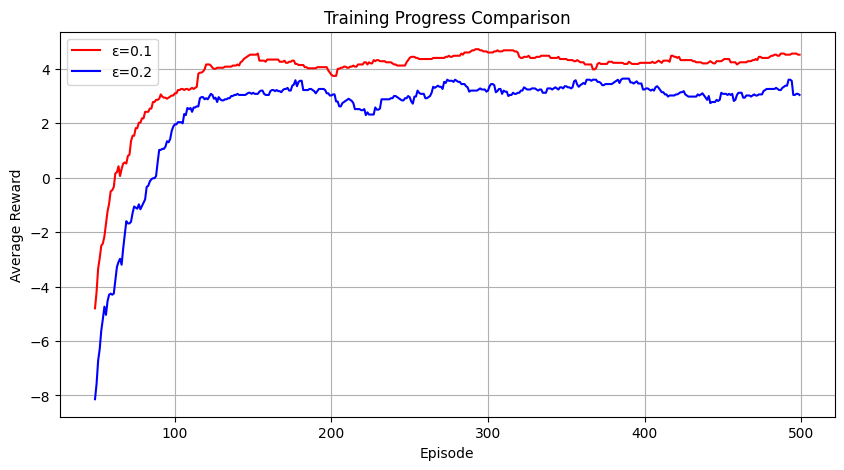

In [71]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

# Run two different training configurations
rewards1 = rl_agent_training(500, 0.1, 0.1, 0.1, 0.99, 20)
rewards2 = rl_agent_training(500, 0.2, 0.2, 0.1, 0.99, 20)

# Calculate moving averages
window_size = 50
moving_avg1 = moving_average(rewards1, window_size)
moving_avg2 = moving_average(rewards2, window_size)

# Plot both moving averages on same graph
plt.figure(figsize=(10, 5))
plt.plot(moving_avg1, color='red', label='ε=0.1')
plt.plot(moving_avg2, color='blue', label='ε=0.2')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Training Progress Comparison')
plt.legend()
plt.grid(True)
plt.show()

The conclusions that we can draw from above graph is that when the probability of random action (epsilon) is 0.1 the moving average is higher than when it is 0.2 as in both cases it has reached a optimal q table but when epsilon is 0.2 it more often performs a random action leading to a lower reward

Also, when epsilon is 0.1, the agents learns faster as it is exploiting a good stratergy more that focusing on exploring as compared to when epsilon is 0.2

Task 3: Experience Replay Buffer